<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/Kaggle/Global_Wheat_Detection/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Load Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from math import floor
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [0]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
class config:
    epochs=1
    batch_size=1
    num_classes=3
    IMAGE_PATH='./data/train/'
    lr=1e-4
    seed=42

In [0]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)

seed_everything(config.seed)

In [0]:
df = pd.read_csv('./data/train.csv')
train_df = os.listdir(config.IMAGE_PATH)
print(len(train_df))
train_df, val_df = train_test_split(train_df, random_state=config.seed, test_size=0.2) # test_size 조정
print(len(train_df), len(val_df))

# Remove empty images from training
# 안지우는게 날것 같음
bad_imgs = []
for id in train_df:
    if len(df[df['image_id'] == id[:-4]]) == 0:
        bad_imgs.append(id)
        
for im in bad_imgs:
    train_df.remove(im)
print(len(train_df), len(val_df))

3422
2737 685
2697 685


## Utils 

In [0]:
def normalize_image(image):
  mean = [0.40789655, 0.44719303, 0.47026116]
  std = [0.2886383, 0.27408165, 0.27809834]
  return ((np.float32(image) / 255.) - mean) / std

from math import floor

def get_boxes(bbox):
  boxes = []
  for box in bbox:
    box = box[1:-1].split(',')
    box = [float(b) for b in box]
    box = [int(b) for b in box]
    boxes.append(box)

  boxes = np.array(boxes, dtype=np.int32)
  return boxes

def heatmap(bbox):
    def get_coords(bbox):
      xs,ys,w,h=[],[],[],[]
      for box in bbox:
        box = box[1:-1].split(',')
        box = [float(b) for b in box]
        box = [int(b) for b in box]

        x1, y1, width, height = box
        xs.append(x1+width//2)
        ys.append(y1+height//2)
        w.append(width)
        h.append(height)
      
      return xs, ys, w, h
    
    def get_heatmap(p_x, p_y):
        X1 = np.linspace(1, 1024, 1024)
        Y1 = np.linspace(1, 1024, 1024)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        sigma_ = 10
        E2 = 2.0 * sigma_ ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap

    coors = []
    size = 20
    y_ = size
    while y_ > -size - 1:
      x_ = -size
      while x_ < size + 1:
        coors.append([x_, y_])
        x_ += 1
      y_ -= 1

    u, v, w, h = get_coords(bbox)
    
    if len(bbox) == 0:
      u = np.array([512])
      v = np.array([512])
      w = np.array([10])
      h = np.array([10])
    
    hm = np.zeros((1024,1024,1))
    width = np.zeros((1024,1024,1))
    height = np.zeros((1024,1024,1))
    for i in range(len(u)):
      for coor in coors:
        try:
          width[int(v[i])+coor[0], int(u[i])+coor[1]] = w[i] / 256
          height[int(v[i])+coor[0], int(u[i])+coor[1]] = h[i] / 256
        except:
          pass
      heatmap = get_heatmap(u[i], v[i])
      hm[:,:] = np.maximum(hm[:,:],heatmap[:,:])
      
    hm = cv2.resize(hm, (256,256))[:,:,None]
    width = cv2.resize(width, (256,256))[:,:,None]
    height = cv2.resize(height, (256,256))[:,:,None]
    return hm, width, height

## Dataset

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=config.IMAGE_PATH, image_paths=None,
                 batch_size=4, dim=(128, 128), n_channels=3,
                 n_classes=3, random_state=config.seed, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.image_paths = image_paths
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
            
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        X = []
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.image_paths[ID]
            img_path = f"{self.base_path}{im_name}"
            img = self.__load_rgb(img_path)
            
            X.append(img)

        X = np.array(X)
        return X
    
    def __generate_y(self, list_IDs_batch):
        y1 = []
        y2 = []
        for i, ID in enumerate(list_IDs_batch):
            image_id = self.image_paths[ID][:-4]
            bbox = self.df[self.df['image_id']==image_id]['bbox']
            mask, width, height = heatmap(bbox)
            y1.append(np.concatenate([mask,width,height], axis=-1))
            y2.append(mask)
        
        y1 = np.array(y1)
        y2 = np.array(y2)
        return [y1,y2]
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        img = normalize_image(img)
        return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


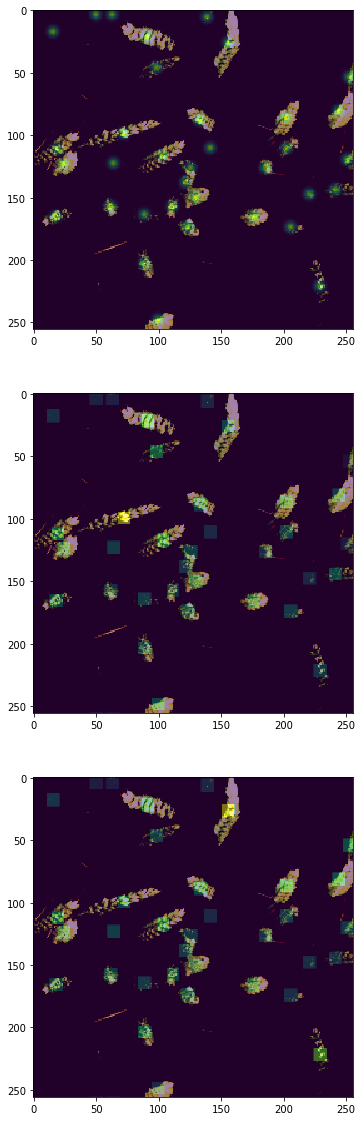

In [0]:
train_gen = DataGenerator(
    list(range(len(train_df))),
    df=df,
    target_df=df,
    batch_size=config.batch_size,
    dim=(1024, 1024),
    n_classes=config.num_classes,
    image_paths=train_df,
    shuffle=True
)

img, regr = train_gen.__getitem__(1)
hm = regr[1][0][:,:,0]
width = regr[0][0][:,:,1]
height = regr[0][0][:,:,2]

img = cv2.resize(img[0], (256,256))

nrow, ncol = 3, 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(img)
        ax.imshow(hm, alpha=0.5)
    elif i == 1:
        ax.imshow(img)
        ax.imshow(width, alpha=0.5)
    else:
        ax.imshow(img)
        ax.imshow(height, alpha=0.5)

## Centernet Model 

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, BatchNormalization, Add, UpSampling2D, ZeroPadding2D, Lambda, Concatenate, Dropout, SpatialDropout2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import get_file

In [0]:
# weights_path = get_file('centernet.hdf5',
#                           'https://github.com/see--/keras-centernet/releases/download/0.1.0/ctdet_coco_hg.hdf5',
#                           cache_subdir='./weights/', 
#                           file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')

In [0]:
def HourglassNetwork(heads, num_stacks, cnv_dim=256, inres=(512, 512), 
                     weights_path='./weights/centernet.hdf5', dims=[256, 384, 384, 384, 512]):
    input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
    inter = pre(input_layer, cnv_dim)
    prev_inter = None
    outputs = []
    for i in range(num_stacks):
        prev_inter = inter
        _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims)
        if i == 1:
            if _heads is not None:
                outputs.extend(_heads)
        if i < num_stacks - 1:
            inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
            inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.1' % i)(inter_)
            
            cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
            cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.1' % i)(cnv_)
            
            inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
            inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
            inter = residual(inter, cnv_dim, 'inters.%d' % i)
    
    model = Model(inputs=input_layer, outputs=outputs)
    
    print('Loading weights...')
    model.load_weights(weights_path, by_name=True)
    print('Done!')
    
    return model

def hourglass_module(heads, bottom, cnv_dim, hgid, dims):
    lfs = left_features(bottom, hgid, dims)

    rf1 = right_features(lfs, hgid, dims)
    rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)

    if heads is not None:
        heads = create_heads(heads, rf1, hgid)
    return heads, rf1

def convolution(_x, k, out_dim, name, stride=1):
    padding = (k - 1) // 2
    _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
    _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

def residual(_x, out_dim, name, stride=1):
    shortcut = _x
    num_channels = K.int_shape(shortcut)[-1]
    _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
    _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
    _x = Activation('relu', name=name + '.relu1')(_x)

    _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)

    if num_channels != out_dim or stride != 1:
        shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
            shortcut)
        shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.1')(shortcut)

    _x = Add(name=name + '.add')([_x, shortcut])
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

def pre(_x, num_channels):
    _x = convolution(_x, 7, 128, name='pre.0', stride=2)
    _x = residual(_x, num_channels, name='pre.1', stride=2)
    return _x

def left_features(bottom, hgid, dims):
    features = [bottom]
    for kk, nh in enumerate(dims):
        pow_str = ''
        for _ in range(kk):
            pow_str += '.center'
        _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=[2, 2])
        _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
        features.append(_x)
    return features

def connect_left_right(left, right, num_channels, num_channels_next, name):
    left = residual(left, num_channels_next, name=name + 'skip.0')
    left = residual(left, num_channels_next, name=name + 'skip.1')

    out = residual(right, num_channels, name=name + 'out.0')
    out = residual(out, num_channels_next, name=name + 'out.1')
    out = UpSampling2D(name=name + 'out.upsampleNN')(out)
    out = Add(name=name + 'out.add')([left, out])
    return out

def bottleneck_layer(_x, num_channels, hgid):
    pow_str = 'center.' * 5
    _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
    return _x

def right_features(leftfeatures, hgid, dims):
    rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
    for kk in reversed(range(len(dims))):
        pow_str = ''
        for _ in range(kk):
            pow_str += 'center.'
        rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
    return rf

def create_heads(heads, rf1, hgid):
    _heads = []
    for head in heads:
        num_channels = heads[head]
        _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
        _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
        _x = Conv2D(num_channels, 1, use_bias=True, name=head + '.%d.1' % hgid)(_x)
        _heads.append(_x)
    return _heads

In [0]:
kwargs = {
    'num_stacks': 2,
    'cnv_dim': 256,
    'inres': (1024, 1024),
}

heads = {
    'regr': 2,
    'confidence': 1
}

model = HourglassNetwork(heads=heads, **kwargs)

Loading weights...
Done!


## Compile Model

In [0]:
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

alpha = .25
gamma = 2
def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    return tf.reduce_mean(loss)

def criterion(y_true, y_pred):
    mask = y_true[:,:,:, 0][:,:,:,np.newaxis]
    regr = y_true[:,:,:, 1:]
    
    regr_loss = mean_squared_error(regr, y_pred)
    loss = regr_loss
    
    return loss

def criterion2(y_true, y_pred):
    mask = y_true[:,:,:, 0][:,:,:,np.newaxis]
    prediction = y_pred
    
    pred_mask = tf.sigmoid(prediction[:,:,:, 0])[:,:,:,np.newaxis]
    mask_loss = focal_loss(mask, pred_mask)
    mask_loss = tf.reduce_mean(mask_loss)
    
    loss = mask_loss
    return loss

optimizer = Adam(lr=config.lr)
model.compile(optimizer=optimizer, loss=[criterion, criterion2], loss_weights=[5, 1])

## Decoder 

In [0]:
def _nms(heat, kernel=3):
    hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
    keep = K.cast(K.equal(hmax, heat), K.floatx())
    return heat * keep

def decode_ddd(regr_, hm_, k, output_stride):
    hm = K.sigmoid(K.expand_dims(hm_[:,:,:,0]))
    regr = regr_
    hm = _nms(hm)
    hm_shape = K.shape(hm)
    regr_shape = K.shape(regr)
    batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]
    
    hm_flat = K.reshape(hm, (batch, -1))
    regr_flat = K.reshape(regr, (regr_shape[0], -1, regr_shape[-1]))
    
    def _process_sample(args):
        _hm, _regr = args
        _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
        _classes = K.cast(_inds % cat, 'float32')
        _inds = K.cast(_inds / cat, 'int32')
        _xs = K.cast(_inds % width, 'float32')
        _ys = K.cast(K.cast(_inds / width, 'int32'), 'float32')
        _xs *= output_stride
        _ys *= output_stride
        
        _regr = K.gather(_regr, _inds)
        
        _width = _regr[:, 0] * 256
        _height = _regr[:, 1] * 256
        
        _detection = K.stack([_xs, _ys, _scores, _classes, _width, _height], -1)
        return _detection
    
    detections = K.map_fn(_process_sample, [hm_flat, regr_flat], dtype=K.floatx())
    return detections

def add_decoder(model, k=125, output_stride=4):
    def _decode(args):
        _regr, _hm = args
        return decode_ddd(_regr, _hm, k=k, output_stride=output_stride)
    
    output = Lambda(_decode)(*[model.outputs])
    model = Model(model.input, output)
    return model

## IOU / Precision Utils 

## MAP

## Training 

## Testing 